In [ ]:
import os
import json

var = r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\base\tit_for_tat"

json_data_list = []

for root, _, files in os.walk(var):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                try:
                    data = json.load(f)
                    json_data_list.append(data)
                except json.JSONDecodeError as e:
                    print(f"Failed to load {file_path}: {e}")
                    
                    

In [ ]:
agent_1_array = []
agent_2_array = []

for i, item in enumerate(json_data_list):
    if not isinstance(item, dict):
        continue
    
    print(item["rounds"])
    print(item["summary"]["llm_model"])
    
    temp1_arr = [item["summary"]["llm_model"]]
    temp2_arr = ["ai"]
    
    for idx, round_data in enumerate(item["rounds"]):
        
        if round_data['Agent1_move'] == 'Cooperate':
            temp1_arr.append(1)
        else:
            temp1_arr.append(0)
            
            
        if round_data['Agent2_move'] == 'Cooperate':
            temp2_arr.append(1)
        else:
            temp2_arr.append(0)
    
    
    agent_1_array.append(temp1_arr)
    agent_2_array.append(temp2_arr)


In [ ]:
import os
import json

scenario = "base"
algorithm = "tit_for_tat"

# Set the directory path
var = f"C:/Users/ryanz/Desktop/UniversityProjects/LLM_Prisoners_Dillemma/prisoner_dilemma_test/llm_vs_ai/results/{scenario}/{algorithm}"

# Load JSON data
json_data_list = []
for root, _, files in os.walk(var):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                try:
                    data = json.load(f)
                    json_data_list.append(data)
                except json.JSONDecodeError as e:
                    print(f"Failed to load {file_path}: {e}")

# Extract moves from each file
agent_1_array = []
agent_2_array = []

for item in json_data_list:
    if not isinstance(item, dict):
        continue

    temp1_arr = [item["summary"]["llm_model"]]
    temp2_arr = [algorithm]

    for round_data in item["rounds"]:
        temp1_arr.append(1 if round_data['Agent1_move'] == 'Cooperate' else 0)
        temp2_arr.append(1 if round_data['Agent2_move'] == 'Cooperate' else 0)

    agent_1_array.append(temp1_arr)
    agent_2_array.append(temp2_arr)

# Combine into a structured result list
results = []

for i in range(len(agent_1_array)):
    result_dict = {
        "scenario": scenario,
        "agent_1": agent_1_array[i][0],
        "agent_2": algorithm,
        "agent_1_moves": agent_1_array[i][1:],
        "agent_2_moves": agent_2_array[i][1:]
    }
    results.append(result_dict)

# Save to JSON
output_path = f"results_{scenario}_{algorithm}.json"
with open(output_path, "w", encoding="utf-8") as out_file:
    json.dump(results, out_file, indent=4)

print(f"Saved {len(results)} records to {output_path}")


In [ ]:
import numpy as np

def behavioural_dimension_analysis(player_moves, opponent_moves):
    """
    Calculate behavioral dimensions for player moves in IPD.

    Args:
        player_moves (list or np.ndarray): Binary array of player's moves (1 = cooperate, 0 = defect), first element = player name
        opponent_moves (list or np.ndarray): Binary array of opponent's moves (1 = cooperate, 0 = defect), first element = opponent name

    Returns:
        dict: {
            "player": player_name,
            "opponent": opponent_name,
            "likelihoods": {
                "Nice": float,
                "Forgiving": float,
                "Retaliatory": float,
                "Troublemaking": float,
                "Emulative": float
            }
        }
    """

    player_name = player_moves[0]
    opponent_name = opponent_moves[0]

    player = np.array(player_moves[1:])
    opponent = np.array(opponent_moves[1:])
    n = len(player)
    
    if len(opponent) != n:
        raise ValueError("player_moves and opponent_moves must be of the same length")

    # Nice: 1 if player never defects first (i.e., player does not defect when opponent cooperated in previous move)
    # For first move: check if player defects immediately (no prior opponent move)
    never_defects_first = True
    if player[0] == 0:  # defected on first move
        never_defects_first = False
    else:
        # Check all moves after first: if player defects while opponent cooperated previous round => defects first
        for t in range(1, n):
            if player[t] == 0 and opponent[t-1] == 1:
                never_defects_first = False
                break
    nice = 1 if never_defects_first else 0

    # Forgiving: (# times player cooperates immediately after opponent defected) / (# opponent defections)
    opp_defections = np.where(opponent == 0)[0]
    if len(opp_defections) == 0:
        forgiving = np.nan  # or 0? No defections to forgive
    else:
        forgive_count = 0
        for t in opp_defections:
            if t + 1 < n and player[t+1] == 1:
                forgive_count += 1
        forgiving = forgive_count / len(opp_defections)

    # Retaliatory: (# times player defects immediately after opponent defected) / (# opponent defections)
    if len(opp_defections) == 0:
        retaliatory = np.nan
    else:
        retaliate_count = 0
        for t in opp_defections:
            if t + 1 < n and player[t+1] == 0:
                retaliate_count += 1
        retaliatory = retaliate_count / len(opp_defections)

    # Troublemaking: (# defections without prior opponent defection) / total moves
    # Defections that occur either at t=0 or after opponent cooperated previous round
    unprovoked_defections = 0
    for t in range(n):
        if player[t] == 0:
            if t == 0:
                unprovoked_defections += 1
            elif opponent[t-1] == 1:
                unprovoked_defections += 1
    troublemaking = unprovoked_defections / n

    # Emulative: (# times player's move at t == opponent's move at t-1) / (n-1)
    if n <= 1:
        emulative = np.nan
    else:
        match_count = 0
        for t in range(1, n):
            if player[t] == opponent[t-1]:
                match_count += 1
        emulative = match_count / (n - 1)

    return {
        "player": player_name,
        "opponent": opponent_name,
        "likelihoods": {
            "Nice": nice,
            "Forgiving": forgiving if not np.isnan(forgiving) else 0,
            "Retaliatory": retaliatory if not np.isnan(retaliatory) else 0,
            "Troublemaking": troublemaking,
            "Emulative": emulative if not np.isnan(emulative) else 0,
        }
    }


In [ ]:
import numpy as np

def sfem_analysis(player_moves, opponent_moves):
    """
    Perform SFEM analysis comparing player_moves to known strategies.
    
    Args:
        player_moves (list or np.ndarray): Binary array of player's moves (1 = cooperate, 0 = defect)
        opponent_moves (list or np.ndarray): Binary array of opponent's moves (1 = cooperate, 0 = defect)
    
    Returns:
        np.ndarray: Normalized likelihood scores for each strategy:
                    [Tit-for-Tat, Always Cooperate, Always Defect, Grim Trigger]
    """
    
    player_name = player_moves[0]
    opponent_name = opponent_moves[0]
    
    player_moves = np.array(player_moves[1:])
    opponent_moves = np.array(opponent_moves[1:])
    n = len(player_moves)

    if len(opponent_moves) != n:
        raise ValueError("player_moves and opponent_moves must be of the same length")

    # Generate expected behavior for each strategy
    expected_tft = np.ones(n)  # first move always cooperate
    expected_tft[1:] = opponent_moves[:-1]  # mirror opponent's previous move

    expected_ac = np.ones(n)  # always cooperate
    expected_ad = np.zeros(n)  # always defect

    expected_gt = np.ones(n)  # cooperate until opponent defects
    triggered = False
    for i in range(n):
        if opponent_moves[i] == 0:
            triggered = True
        if triggered:
            expected_gt[i] = 0

    # Compute match rates
    strategies = [expected_tft, expected_ac, expected_ad, expected_gt]
    likelihoods = np.array([
        np.mean(player_moves == strategy) for strategy in strategies
    ])
    
    

    # Normalize to sum to 1
    likelihoods /= np.sum(likelihoods)

    return {
        "player": player_name,
        "opponent": opponent_name,
        "likelihoods": {
            "Tit-for-Tat": likelihoods[0],
            "Always Cooperate": likelihoods[1],
            "Always Defect": likelihoods[2],
            "Grim Trigger": likelihoods[3]
        }
    }

In [ ]:
import os
import json

# === LOOP THROUGH EACH CASE ===
base_dir = r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\base"
scenarios = ["tit_for_tat", "20_defection_rate", "50_defection_rate", "80_defection_rate"]

for scenario in scenarios:
    scenario_path = os.path.join(base_dir, scenario)
    print(f"\n--- Scenario: {scenario} ---")

    json_data_list = []

    for root, _, files in os.walk(scenario_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)
                        json_data_list.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Failed to load {file_path}: {e}")

    agent_1_array = []
    agent_2_array = []

    for item in json_data_list:
        if not isinstance(item, dict):
            continue

        temp1_arr = [item["summary"]["llm_model"]]
        temp2_arr = ["ai"]

        for round_data in item["rounds"]:
            temp1_arr.append(1 if round_data['Agent1_move'] == 'Cooperate' else 0)
            temp2_arr.append(1 if round_data['Agent2_move'] == 'Cooperate' else 0)

        agent_1_array.append(temp1_arr)
        agent_2_array.append(temp2_arr)

    results = []
    for model in range(len(agent_1_array)):
        player = agent_1_array[model]
        opposition = agent_2_array[model]
        result = sfem_analysis(player, opposition)
        results.append(result)

    for res in results:
        print(f"{res['player']} vs {res['opponent']}")
        for strat, score in res['likelihoods'].items():
            print(f"  {strat}: {score:.2f}")
        print()

sfem_analysis

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict

def sfem_analysis(player_moves, opponent_moves):
    player_name = player_moves[0]
    opponent_name = opponent_moves[0]

    player_moves = np.array(player_moves[1:])
    opponent_moves = np.array(opponent_moves[1:])
    n = len(player_moves)

    if len(opponent_moves) != n:
        raise ValueError("player_moves and opponent_moves must be of the same length")

    expected_tft = np.ones(n)
    expected_tft[1:] = opponent_moves[:-1]

    expected_ac = np.ones(n)
    expected_ad = np.zeros(n)

    expected_gt = np.ones(n)
    triggered = False
    for i in range(n):
        if opponent_moves[i] == 0:
            triggered = True
        if triggered:
            expected_gt[i] = 0

    strategies = [expected_tft, expected_ac, expected_ad, expected_gt]
    likelihoods = np.array([
        np.mean(player_moves == strategy) for strategy in strategies
    ])
    likelihoods /= max(np.sum(likelihoods), 1e-10)

    return {
        "player": player_name,
        "opponent": opponent_name,
        "likelihoods": {
            "Tit-for-Tat": likelihoods[0],
            "Always Cooperate": likelihoods[1],
            "Always Defect": likelihoods[2],
            "Grim Trigger": likelihoods[3]
        }
    }

# === LOOP THROUGH EACH CASE ===
base_dir = r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role"
scenarios = ["tit_for_tat", "20_defection_rate", "50_defection_rate", "80_defection_rate"]

output_data = []

for scenario in scenarios:
    scenario_path = os.path.join(base_dir, scenario)
    print(f"\n--- Scenario: {scenario} ---")

    json_data_list = []

    for root, _, files in os.walk(scenario_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)
                        json_data_list.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Failed to load {file_path}: {e}")

    agent_1_array = []
    agent_2_array = []

    for item in json_data_list:
        if not isinstance(item, dict):
            continue

        temp1_arr = [item["summary"]["llm_model"]]
        temp2_arr = ["ai"]

        for round_data in item["rounds"]:
            temp1_arr.append(1 if round_data['Agent1_move'] in ['Cooperate', 'Concede'] else 0)
            temp2_arr.append(1 if round_data['Agent2_move'] in ['Cooperate', 'Concede'] else 0)

        agent_1_array.append(temp1_arr)
        agent_2_array.append(temp2_arr)

    results = []
    for model in range(len(agent_1_array)):
        player = agent_1_array[model]
        opposition = agent_2_array[model]
        result = sfem_analysis(player, opposition)
        results.append(result)

    # === Group & Average by Model ===
    grouped_results = defaultdict(list)

    for res in results:
        grouped_results[res["player"]].append(res["likelihoods"])

    for model_name, likelihood_dicts in grouped_results.items():
        sum_likelihoods = defaultdict(float)
        for d in likelihood_dicts:
            for strat, val in d.items():
                sum_likelihoods[strat] += val

        count = len(likelihood_dicts)
        avg_likelihoods = {k: v / count for k, v in sum_likelihoods.items()}

        output_data.append({
            "scenario": "role",
            "opposing_strategy": scenario,
            "avg_count": count,
            "model_name": model_name,
            "likelihoods": avg_likelihoods
        })

# === Write Output to JSON ===
output_path = os.path.join("./z_final_results/vs_ai/sfem", "role_sfem_summary.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=4)

print(f"\n SFEM summary saved to: {output_path}")


bheavioural_dimentiosn_analysis V

In [ ]:
import os
import json
import numpy as np

def behavioural_dimension_analysis(player_moves, opponent_moves):
    player_name = player_moves[0]
    opponent_name = opponent_moves[0]

    player = np.array(player_moves[1:])
    opponent = np.array(opponent_moves[1:])
    n = len(player)
    
    if len(opponent) != n:
        raise ValueError("player_moves and opponent_moves must be of the same length")

    # Nice
    never_defects_first = True
    if player[0] == 0:
        never_defects_first = False
    else:
        for t in range(1, n):
            if player[t] == 0 and opponent[t-1] == 1:
                never_defects_first = False
                break
    nice = 1 if never_defects_first else 0

    # Forgiving
    opp_defections = np.where(opponent == 0)[0]
    if len(opp_defections) == 0:
        forgiving = -1
    else:
        forgive_count = sum(1 for t in opp_defections if t + 1 < n and player[t+1] == 1)
        forgiving = forgive_count / len(opp_defections)

    # Retaliatory
    if len(opp_defections) == 0:
        retaliatory = -1
    else:
        retaliate_count = sum(1 for t in opp_defections if t + 1 < n and player[t+1] == 0)
        retaliatory = retaliate_count / len(opp_defections)


    # Troublemaking
    unprovoked_defections = 0
    for t in range(n):
        if player[t] == 0:
            if t == 0 or opponent[t-1] == 1:
                unprovoked_defections += 1
    troublemaking = unprovoked_defections / n

    # Emulative
    if n <= 1:
        emulative = -1
    else:
        match_count = sum(1 for t in range(1, n) if player[t] == opponent[t-1])
        emulative = match_count / (n - 1)

    return {
        "player": player_name,
        "opponent": opponent_name,
        "likelihoods": {
            "Nice": nice,
            "Forgiving": forgiving,
            "Retaliatory": retaliatory,
            "Troublemaking": troublemaking,
            "Emulative": emulative,
        }
    }


# Define your scenarios and paths here
scenarios = {
    "20_defection_rate": r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role\20_defection_rate",
    "50_defection_rate": r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role\50_defection_rate",
    "80_defection_rate": r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role\80_defection_rate",
    "tit_for_tat": r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role\tit_for_tat"
}

all_results = []

for scenario_name, scenario_path in scenarios.items():
    print(f"Processing scenario: {scenario_name}")
    
    json_data_list = []
    for root, _, files in os.walk(scenario_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)
                        json_data_list.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Failed to load {file_path}: {e}")

    agent_1_array = []
    agent_2_array = []

    for item in json_data_list:
        if not isinstance(item, dict):
            continue
        
        # Extract model and opponent names
        model_name = item.get("summary", {}).get("llm_model", "unknown_model")
        opponent_name = "ai"  # or extract if available differently
        
        temp1_arr = [model_name]
        temp2_arr = [opponent_name]
        
        rounds = item.get("rounds", [])
        for round_data in rounds:
            temp1_arr.append(1 if round_data['Agent1_move'] in ['Cooperate', 'Concede'] else 0)
            temp2_arr.append(1 if round_data['Agent2_move'] in ['Cooperate', 'Concede'] else 0)
        
        agent_1_array.append(temp1_arr)
        agent_2_array.append(temp2_arr)

    # Run analysis for each match
    for i in range(len(agent_1_array)):
        player = agent_1_array[i]
        opponent = agent_2_array[i]

        # Perform behavioral dimension analysis
        analysis_result = behavioural_dimension_analysis(player, opponent)

        # Compose final dict for saving
        result_dict = {
            "scenario": "role",
            "model_name":   analysis_result["player"],
            "opposing_strategy": scenario_name,
            "behavioral_dimensions": analysis_result["likelihoods"]
        }

        all_results.append(result_dict)

# Save all results to JSON
output_path = os.path.join("./z_final_results/vs_ai/behavioural", "role_behavioural_analyses.json")
with open(output_path, "w", encoding="utf-8") as out_file:
    json.dump(all_results, out_file, indent=4)

print(f"Analysis complete. Results saved to {output_path}")


probablistic sfem

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize

# [Include the corrected SFEM functions from the previous artifact here]
def softmax(x):
    """Convert logits to probabilities"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def compute_strategy_predictions(opponent_moves):
    """
    Compute what each strategy would do given opponent's history
    Returns: (n_strategies, n_rounds) array where each entry is the predicted action (0 or 1)
    """
    n = len(opponent_moves)
    
    # Tit-for-Tat: Cooperate first, then copy opponent's previous move
    tft = np.ones(n)
    if n > 1:
        tft[1:] = opponent_moves[:-1]
    
    # Always Cooperate
    always_coop = np.ones(n)
    
    # Always Defect
    always_defect = np.zeros(n)
    
    # Grim Trigger: Cooperate until opponent defects once, then always defect
    grim = np.ones(n)
    triggered = False
    for i in range(n):
        if i > 0 and opponent_moves[i-1] == 0:  # Opponent defected in previous round
            triggered = True
        if triggered:
            grim[i] = 0
    
    return np.vstack([tft, always_coop, always_defect, grim])

def neg_log_likelihood(log_weights, player_moves, strategy_preds):
    """
    Compute negative log-likelihood of the mixture model
    """
    weights = softmax(log_weights)
    eps = 1e-12  # numerical stability
    
    n_strategies, n_rounds = strategy_preds.shape
    total_log_likelihood = 0.0
    
    # For each round t
    for t in range(n_rounds):
        actual_action = player_moves[t]
        
        # Compute mixture probability for this round
        mixture_prob = 0.0
        for i in range(n_strategies):
            strategy_prediction = strategy_preds[i, t]
            
            # P(a_t | s_i): probability that strategy i predicts actual action
            if actual_action == 1:  # Player cooperated
                prob_action_given_strategy = strategy_prediction
            else:  # Player defected
                prob_action_given_strategy = 1 - strategy_prediction
            
            mixture_prob += weights[i] * prob_action_given_strategy
        
        # Add log of mixture probability (with numerical stability)
        total_log_likelihood += np.log(mixture_prob + eps)
    
    return -total_log_likelihood  # Return negative for minimization

def sfem_analysis(player_moves, opponent_moves):
    """
    Perform probabilistic SFEM analysis
    """
    player_name = player_moves[0]
    opponent_name = opponent_moves[0]
    
    player_moves_data = np.array(player_moves[1:], dtype=float)
    opponent_moves_data = np.array(opponent_moves[1:], dtype=float)
    
    if len(player_moves_data) != len(opponent_moves_data):
        raise ValueError("player_moves and opponent_moves must have the same length")
    
    if len(player_moves_data) == 0:
        raise ValueError("No moves to analyze")
    
    # Compute what each strategy would predict
    strategy_preds = compute_strategy_predictions(opponent_moves_data)
    
    # Initialize weights (log scale for numerical stability)
    init_log_weights = np.zeros(strategy_preds.shape[0])
    
    try:
        # Optimize mixture weights
        result = minimize(
            neg_log_likelihood,
            init_log_weights,
            args=(player_moves_data, strategy_preds),
            method='L-BFGS-B',
            options={'maxiter': 1000}
        )
        
        if not result.success:
            print(f"Warning: Optimization did not converge for {player_name}. Message: {result.message}")
        
        # Convert back to probabilities
        strategy_weights = softmax(result.x)
        
    except Exception as e:
        print(f"Error in optimization for {player_name}: {e}")
        # Return uniform weights as fallback
        strategy_weights = np.ones(strategy_preds.shape[0]) / strategy_preds.shape[0]
        result = None
    
    strategy_names = ["Tit-for-Tat", "Always Cooperate", "Always Defect", "Grim Trigger"]
    
    return {
        "player": player_name,
        "opponent": opponent_name,
        "log_likelihood": -result.fun if result and result.success else None,
        "convergence": result.success if result else False,
        "strategy_weights": {
            strategy_names[i]: float(strategy_weights[i]) 
            for i in range(len(strategy_names))
        }
    }

# === MAIN ANALYSIS LOOP ===
base_dir = r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\prisoner_dilemma_test\llm_vs_ai\results\role"
scenarios = ["tit_for_tat", "20_defection_rate", "50_defection_rate", "80_defection_rate"]

output_data = []

for scenario in scenarios:
    scenario_path = os.path.join(base_dir, scenario)
    print(f"\n--- Scenario: {scenario} ---")

    json_data_list = []

    # Load all JSON files in the scenario directory
    for root, _, files in os.walk(scenario_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    try:
                        data = json.load(f)
                        json_data_list.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Failed to load {file_path}: {e}")

    # Process each game and prepare data for SFEM analysis
    agent_1_array = []
    agent_2_array = []

    for item in json_data_list:
        if not isinstance(item, dict):
            continue

        # Skip if no rounds data
        if "rounds" not in item or not item["rounds"]:
            print(f"Skipping item with no rounds data")
            continue

        # Extract player name and moves
        temp1_arr = [item["summary"]["llm_model"]]
        temp2_arr = ["ai"]

        for round_data in item["rounds"]:
            temp1_arr.append(1 if round_data['Agent1_move'] in ['Cooperate', 'Concede'] else 0)
            temp2_arr.append(1 if round_data['Agent2_move'] in ['Cooperate', 'Concede'] else 0)

        # Only add if we have actual game data
        if len(temp1_arr) > 1:  # More than just the name
            agent_1_array.append(temp1_arr)
            agent_2_array.append(temp2_arr)

    print(f"Processing {len(agent_1_array)} games for scenario {scenario}")

    # Run SFEM analysis on each game
    results = []
    for model in range(len(agent_1_array)):
        player = agent_1_array[model]
        opposition = agent_2_array[model]
        
        print(player)
        print(opposition)
        
        try:
            result = sfem_analysis(player, opposition)
            print(result)
            results.append(result)
        except Exception as e:
            print(f"Error analyzing game {model} in scenario {scenario}: {e}")
            continue

    if not results:
        print(f"No valid results for scenario {scenario}")
        continue

    # === Group & Average by Model ===
    grouped_results = defaultdict(list)

    for res in results:
        grouped_results[res["player"]].append(res["strategy_weights"])

    # Calculate averages for each model
    for model_name, weight_dicts in grouped_results.items():
        sum_weights = defaultdict(float)
        valid_count = 0
        
        for d in weight_dicts:
            if d is not None:  # Skip failed analyses
                for strategy, weight in d.items():
                    sum_weights[strategy] += weight
                valid_count += 1

        if valid_count > 0:
            avg_weights = {k: v / valid_count for k, v in sum_weights.items()}
            
            output_data.append({
                "scenario": "role",
                "opposing_strategy": scenario,
                "games_analyzed": valid_count,
                "total_games": len(weight_dicts),
                "model_name": model_name,
                "strategy_weights": avg_weights
            })
            
            print(f"Model {model_name}: {valid_count}/{len(weight_dicts)} games analyzed successfully")

# === Create output directory if it doesn't exist ===
output_dir = "./z_final_results/vs_llm/probabilistic_sfem"
os.makedirs(output_dir, exist_ok=True)

# === Write Output to JSON ===
output_path = os.path.join(output_dir, "role_sfem_summary.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output_data, f, indent=4)

print(f"\nSFEM summary saved to: {output_path}")
print(f"Total entries saved: {len(output_data)}")

# === Print Summary Statistics ===
print("\n=== SUMMARY ===")
for entry in output_data:
    print(f"\nScenario: {entry['opposing_strategy']}")
    print(f"Model: {entry['model_name']}")
    print(f"Games: {entry['games_analyzed']}/{entry['total_games']}")
    print("Strategy Weights:")
    for strategy, weight in entry['strategy_weights'].items():
        print(f"  {strategy}: {weight:.3f}")

sfem outputs

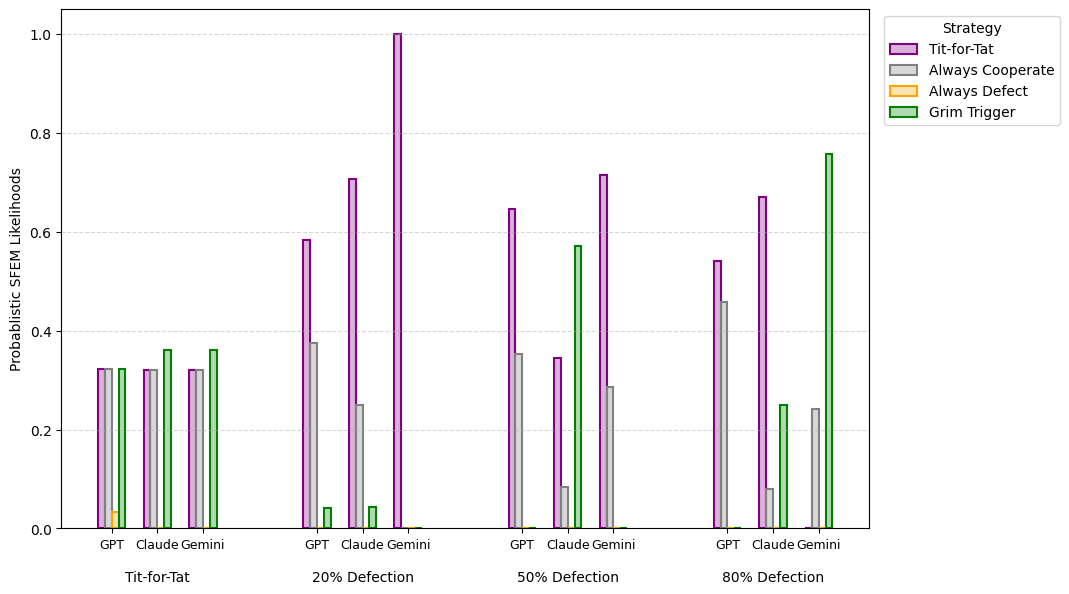

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# === Load data ===
with open(r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\z_final_results\vs_ai\probabilistic_sfem\emotional_sfem_summary.json", "r", encoding="utf-8") as f:
    sfem_data = json.load(f)

# === Setup ===
strategies = ["Tit-for-Tat", "Always Cooperate", "Always Defect", "Grim Trigger"]
colors = ['purple', 'grey', 'orange', 'green']
opposing_strategies = ["tit_for_tat", "20_defection_rate", "50_defection_rate", "80_defection_rate"]

# Friendly strategy names
pretty_opp_map = {
    "tit_for_tat": "Tit-for-Tat",
    "20_defection_rate": "20% Defection",
    "50_defection_rate": "50% Defection",
    "80_defection_rate": "80% Defection",
}

# Map raw model names to shorter ones
name_map = {
    "gpt-4o": "GPT",
    "claude-sonnet": "Claude",
    "gemini": "Gemini",
}

def resolve_model_name(raw):
    raw = raw.lower()
    for k, v in name_map.items():
        if k in raw:
            return v
    return raw

# === Preprocess data ===
bar_width = 0.15
gap_between_groups = 1.5  # wider gap between opponent groups
x_positions = []
group_labels = []
data_groups = []
opponent_centers = []  # for centered opponent strategy labels

x = 0
for opp in opposing_strategies:
    filtered = [d for d in sfem_data if d["opposing_strategy"] == opp]
    # filtered = sorted(filtered, key=lambda d: resolve_model_name(d["model_name"]))  # optional sort
    group_start = x
    for entry in filtered:
        group_labels.append(resolve_model_name(entry["model_name"]))
        data_groups.append(entry["likelihoods"])
        x_positions.append(x)
        x += 1
    group_end = x - 1
    opponent_centers.append((group_start + group_end) / 2)
    x += gap_between_groups  # add spacing after each group

# === Plot ===
fig, ax = plt.subplots(figsize=(len(x_positions) * 0.9, 6))

x = np.array(x_positions)

for i, (strategy, color) in enumerate(zip(strategies, colors)):
    rgba_color = mcolors.to_rgba(color, alpha=0.3)
    heights = [d[strategy] for d in data_groups]
    ax.bar(
        x + i * bar_width - 1.5 * bar_width,
        heights,
        bar_width,
        edgecolor=color,
        facecolor=rgba_color,
        linewidth=1.5,
        label=strategy
    )

# === Custom ticks and labels ===
ax.set_xticks(x)
ax.set_xticklabels(group_labels, rotation=0, ha='center', fontsize=9)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Probablistic SFEM Likelihoods")
# ax.set_title("Grouped SFEM Strategy Frequencies by Opponent and Model")
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# === Centered Opponent Labels ===
y_min = -0.08  # vertical placement (below x-axis ticks)
for center, opp in zip(opponent_centers, opposing_strategies):
    ax.text(center, y_min, pretty_opp_map[opp], ha='center', va='top', fontsize=10, transform=ax.get_xaxis_transform())

# === Legend ===
ax.legend(title="Strategy", loc='upper left', bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.show()

Behavioural Analyses
Table

In [33]:
import json
import pandas as pd
import numpy as np

# Load the data
with open(r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\z_final_results\vs_ai\behavioural\emotional_behavioural_analyses.json") as f:
    data = json.load(f)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Expand the behavioral_dimensions column into separate columns
behavioral_cols = pd.json_normalize(df['behavioral_dimensions'])
df = pd.concat([df.drop('behavioral_dimensions', axis=1), behavioral_cols], axis=1)

# Group by model_name and opposing_strategy, then calculate means
grouped = df.groupby(['model_name', 'opposing_strategy']).agg({
    'Nice': 'mean',
    'Forgiving': 'mean', 
    'Retaliatory': 'mean',
    'Troublemaking': 'mean',
    'Emulative': 'mean'
}).round(3)

# Reset index to make it easier to work with
grouped_reset = grouped.reset_index()

# Create a pivot table for better presentation
pivot_table = grouped_reset.pivot(index='model_name', columns='opposing_strategy', values=['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative'])

print("=== BEHAVIORAL DIMENSIONS BY MODEL AND OPPOSING STRATEGY ===")
print("(Values are averages across all games with same model and opposing strategy)")
print()

# Print the pivot table in a more readable format
for behavior in ['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']:
    print(f"--- {behavior.upper()} ---")
    behavior_table = pivot_table[behavior].fillna('-')
    print(behavior_table.to_string())
    print()

# Alternative: Create a single comprehensive table
print("=== COMPREHENSIVE TABLE ===")
print()

# Reshape for a single table with multi-level columns
comprehensive_table = pd.DataFrame()

for model in grouped_reset['model_name'].unique():
    model_data = grouped_reset[grouped_reset['model_name'] == model]
    model_data_formatted = model_data.set_index('opposing_strategy')[['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']].T
    model_data_formatted.columns = [f"{model}_{col}" for col in model_data_formatted.columns]
    if comprehensive_table.empty:
        comprehensive_table = model_data_formatted
    else:
        comprehensive_table = pd.concat([comprehensive_table, model_data_formatted], axis=1)

print(comprehensive_table.to_string())
print()

# Create a clean table for academic presentation
print("=== ACADEMIC PRESENTATION TABLE ===")
print()

# Clean model names for presentation
model_name_mapping = {
    'openai_gpt-4o-mini': 'GPT-4o-mini',
    'anthropic_claude-sonnet-4': 'Claude Sonnet 4', 
    'google_gemini-2.0-flash-001': 'Gemini 2.0 Flash'
}

# Clean strategy names
strategy_name_mapping = {
    '20_defection_rate': '20% Defection',
    '50_defection_rate': '50% Defection', 
    '80_defection_rate': '80% Defection',
    'tit_for_tat': 'Tit-for-Tat'
}

# Create the final presentation table
final_table = grouped_reset.copy()
final_table['model_name'] = final_table['model_name'].map(model_name_mapping)
final_table['opposing_strategy'] = final_table['opposing_strategy'].map(strategy_name_mapping) 

# Sort by model and strategy for consistent presentation
final_table = final_table.sort_values(['model_name', 'opposing_strategy'])

print("Table 1: Behavioral Dimensions by Model and Opposing Strategy")
print("=" * 80)
print(f"{'Model':<18} {'Strategy':<15} {'Nice':<6} {'Forg.':<6} {'Retal.':<6} {'Trouble':<8} {'Emul.':<6}")
print("-" * 80)

for _, row in final_table.iterrows():
    print(f"{row['model_name']:<18} {row['opposing_strategy']:<15} {row['Nice']:<6.3f} {row['Forgiving']:<6.3f} {row['Retaliatory']:<6.3f} {row['Troublemaking']:<8.3f} {row['Emulative']:<6.3f}")

print()
print("Note: Values represent mean scores across all games for each model-strategy combination.")
print("Forg. = Forgiving, Retal. = Retaliatory, Trouble = Troublemaking, Emul. = Emulative")

=== BEHAVIORAL DIMENSIONS BY MODEL AND OPPOSING STRATEGY ===
(Values are averages across all games with same model and opposing strategy)

--- NICE ---
opposing_strategy            20_defection_rate  50_defection_rate  80_defection_rate  tit_for_tat
model_name                                                                                       
anthropic_claude-sonnet-4                  0.0                0.0                0.0          1.0
google_gemini-2.0-flash-001                1.0                1.0                0.0          1.0
openai_gpt-4o-mini                         0.5                1.0                1.0          0.0

--- FORGIVING ---
opposing_strategy            20_defection_rate  50_defection_rate  80_defection_rate  tit_for_tat
model_name                                                                                       
anthropic_claude-sonnet-4                0.250              0.083              0.080         -1.0
google_gemini-2.0-flash-001              0.00

Visual

Creating visualizations...
1. Radar Charts (Most comprehensive)


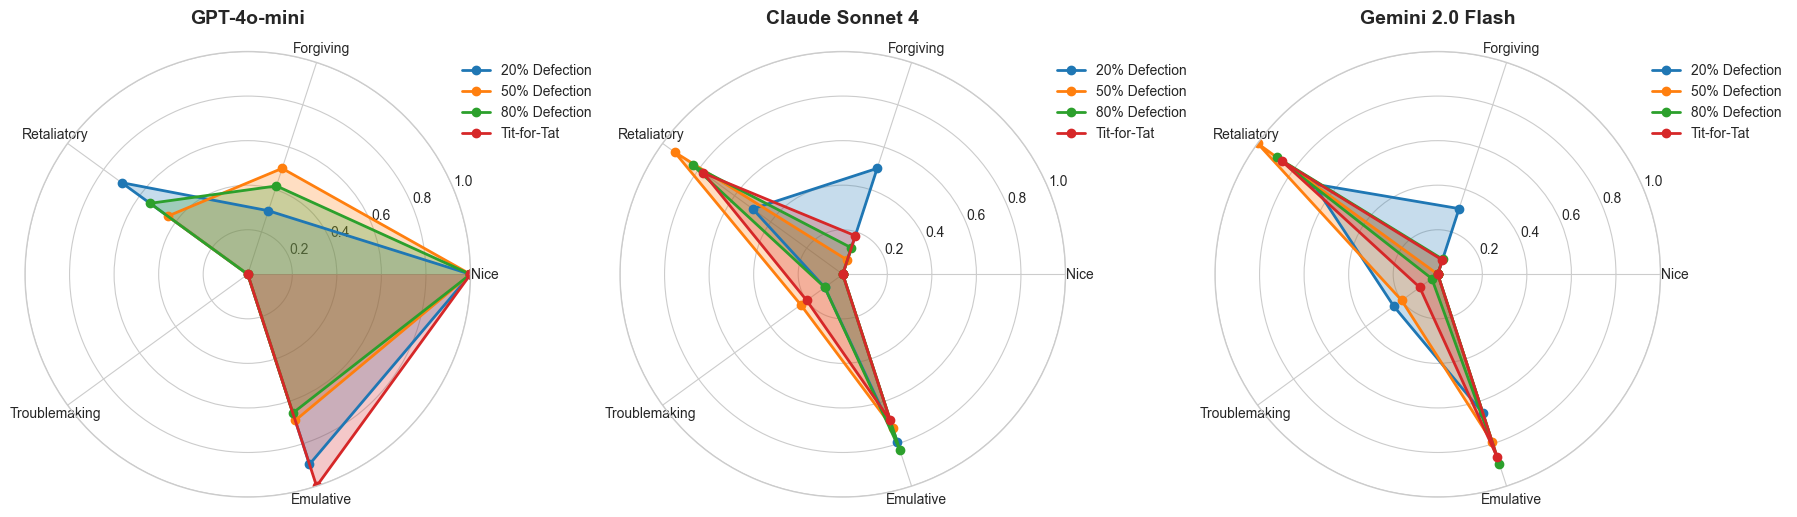

In [40]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Set style for academic papers
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load and process data
with open(r"C:\Users\ryanz\Desktop\UniversityProjects\LLM_Prisoners_Dillemma\z_final_results\vs_ai\behavioural\role_behavioural_analyses.json") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
behavioral_cols = pd.json_normalize(df['behavioral_dimensions'])
df = pd.concat([df.drop('behavioral_dimensions', axis=1), behavioral_cols], axis=1)

# Group and average
grouped = df.groupby(['model_name', 'opposing_strategy']).agg({
    'Nice': 'mean',
    'Forgiving': 'mean', 
    'Retaliatory': 'mean',
    'Troublemaking': 'mean',
    'Emulative': 'mean'
}).round(3).reset_index()

# Clean names for visualization
model_name_mapping = {
    'openai_gpt-4o-mini': 'GPT-4o-mini',
    'anthropic_claude-sonnet-4': 'Claude Sonnet 4', 
    'google_gemini-2.0-flash-001': 'Gemini 2.0 Flash'
}

strategy_name_mapping = {
    '20_defection_rate': '20% Defection',
    '50_defection_rate': '50% Defection', 
    '80_defection_rate': '80% Defection',
    'tit_for_tat': 'Tit-for-Tat'
}

grouped['model_name'] = grouped['model_name'].map(model_name_mapping)
grouped['opposing_strategy'] = grouped['opposing_strategy'].map(strategy_name_mapping)

# 1. RADAR CHARTS - Most effective for behavioral analysis
def create_radar_charts():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='polar'))
    
    # Behavioral dimensions
    categories = ['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']
    N = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    strategies = grouped['opposing_strategy'].unique()
    
    for idx, model in enumerate(['GPT-4o-mini', 'Claude Sonnet 4', 'Gemini 2.0 Flash']):
        ax = axes[idx]
        model_data = grouped[grouped['model_name'] == model]
        
        for i, strategy in enumerate(strategies):
            strategy_data = model_data[model_data['opposing_strategy'] == strategy]
            if not strategy_data.empty:
                values = strategy_data[categories].values.flatten().tolist()
                values += values[:1]  # Complete the circle
                
                ax.plot(angles, values, 'o-', linewidth=2, label=strategy, color=colors[i])
                ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title(f'{model}', size=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
    
    plt.tight_layout()
    # plt.suptitle('Behavioral Dimensions by Model and Opposing Strategy', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# 2. HEATMAP - Great for academic papers
def create_heatmap():
    # Pivot data for heatmap
    heatmap_data = grouped.set_index(['model_name', 'opposing_strategy'])[['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu_r', center=0.5, 
                fmt='.3f', cbar_kws={'label': 'Behavioral Score'})
    plt.title('Behavioral Dimensions Heatmap by Model and Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Behavioral Dimensions', fontsize=12)
    plt.ylabel('Model and Strategy', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 3. GROUPED BAR CHARTS - Good for comparing specific dimensions
def create_grouped_bar_charts():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    behaviors = ['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']
    
    for idx, behavior in enumerate(behaviors):
        ax = axes[idx]
        
        # Pivot for grouped bar chart
        pivot_data = grouped.pivot(index='opposing_strategy', columns='model_name', values=behavior)
        pivot_data.plot(kind='bar', ax=ax, width=0.8)
        
        ax.set_title(f'{behavior}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Opposing Strategy')
        ax.set_ylabel('Score')
        ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 1.1)
    
    # Remove the empty subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.suptitle('Behavioral Dimensions Comparison Across Models and Strategies', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# 4. LINE PLOTS - Good for showing strategy adaptation
def create_line_plots():
    # Create a mapping for strategy ordering
    strategy_order = ['20% Defection', '50% Defection', '80% Defection', 'Tit-for-Tat']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    behaviors = ['Nice', 'Forgiving', 'Retaliatory', 'Troublemaking', 'Emulative']
    
    for idx, behavior in enumerate(behaviors):
        ax = axes[idx]
        
        for model in ['GPT-4o-mini', 'Claude Sonnet 4', 'Gemini 2.0 Flash']:
            model_data = grouped[grouped['model_name'] == model]
            # Sort by strategy order
            model_data = model_data.set_index('opposing_strategy').reindex(strategy_order).reset_index()
            
            ax.plot(model_data['opposing_strategy'], model_data[behavior], 
                   marker='o', linewidth=2, markersize=6, label=model)
        
        ax.set_title(f'{behavior}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Opposing Strategy')
        ax.set_ylabel('Score')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3)
    
    # Remove the empty subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.suptitle('Behavioral Adaptation Across Different Opposing Strategies', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# 5. COMPACT ACADEMIC FIGURE - Best for papers with space constraints
def create_academic_figure():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left panel: Heatmap of key behaviors
    key_behaviors = ['Nice', 'Retaliatory', 'Emulative']
    heatmap_data = grouped.set_index(['model_name', 'opposing_strategy'])[key_behaviors]
    
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu_r', center=0.5, 
                fmt='.2f', ax=ax1, cbar_kws={'label': 'Score'})
    ax1.set_title('Key Behavioral Dimensions', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Behavioral Dimension')
    ax1.set_ylabel('Model and Strategy')
    
    # Right panel: Model comparison for Retaliatory behavior
    pivot_data = grouped.pivot(index='opposing_strategy', columns='model_name', values='Retaliatory')
    pivot_data.plot(kind='bar', ax=ax2, width=0.7)
    ax2.set_title('Retaliatory Behavior by Strategy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Opposing Strategy')
    ax2.set_ylabel('Retaliatory Score')
    ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

# Execute visualizations
print("Creating visualizations...")
print("1. Radar Charts (Most comprehensive)")
create_radar_charts()

# print("\n2. Heatmap (Best for academic papers)")
# create_heatmap()

# print("\n3. Grouped Bar Charts (Detailed comparison)")
# create_grouped_bar_charts()

# print("\n4. Line Plots (Strategy adaptation)")
# create_line_plots()

# print("\n5. Compact Academic Figure (Space-efficient)")
# create_academic_figure()

# print("\nAll visualizations created! Choose the one that best fits your paper's needs.")